- 
github 출력 안보이는 경우 [nbviewer](https://nbviewer.org/github/nidolight/AIffel_GoingDeeper/blob/main/%5BG-04%5DCutmix_Mixup_augmentation/%5BG_04%5DCutmix_Mixup_augmentation.ipynb)에서 확인

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

## 1. Augmentation을 적용한 데이터셋 만들기

우선 `tfds`를 통해 데이터를 불러옵니다.

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True, as_supervised=True, #as_supervised=True 옵션을 주면 dict 형태가 아닌 tuple 형태로 데이터를 return 받습니다.
    with_info=True,
)
num_classes = ds_info.features["label"].num_classes
num_classes

120

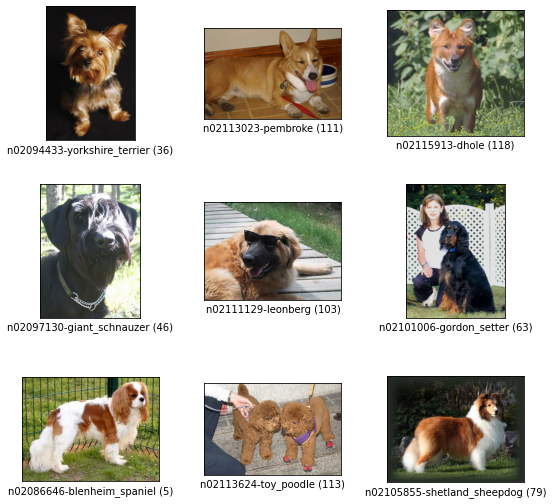

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

 ### normalize_and_resize_img
 - 입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize합니다.

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

### 기본 Augmentation
- 입력받은 이미지를 무작위로 좌우대칭 해주거나 밝기를 변경해줍니다.

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    # image = tf.clip_by_value(image, 0, 1)
    return image, label

기본 Augmentation외에 Cutmix와 Mixup을 사용해보려고 합니다.
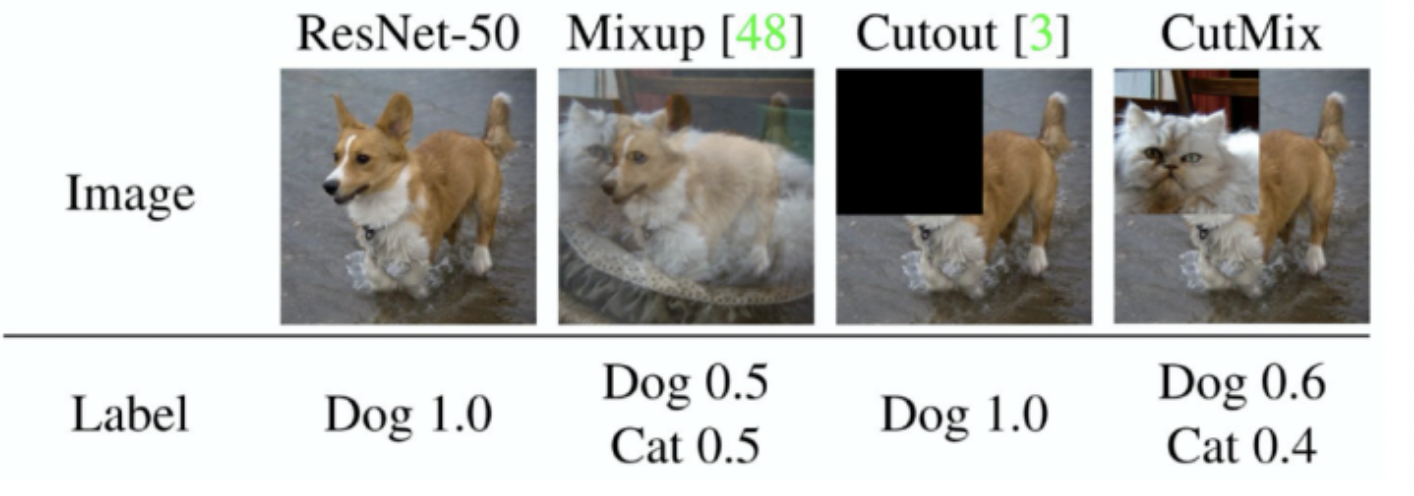

### Cutmix Augmentation
Cutmix Augmentation은 이미지 데이터를 자르고 섞습니다.<br>
이미지 a, b가 모두 (224, 224)로 resize되어 두 이미지의 width, height가 같은 경우로 가정할 수 있지만, CutMix 공식 repo 에서는 width, height가 다르더라도 가변적으로 적용할 수 있도록 구현되어 있기 때문에, 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현합니다.

  - `get_clip_box` : `image_a`를 바탕 이미지로 하고 거기에 삽입할 `image_b`가 있을 때, `image_a`에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수

In [ ]:
def get_clip_box(image_a, image_b,img_size=224):  
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, img_size), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, img_size), tf.int32)

    # get width, height of box
    width = tf.cast(img_size*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(img_size*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(img_size, x+width//2)
    y_max = tf.math.minimum(img_size, y+width//2)
    
    return x_min, y_min, x_max, y_max

- `mix_2_images` : 바탕이미지 `image_a`에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 `image_b`에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max, img_size=224):
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:img_size, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:img_size, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

이미지를 섞었다면 라벨도 이에 맞게 섞어주어야 합니다.<br>
CutMix에서는 면적에 비례해서 라벨을 섞어줍니다. 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해줍니다

- `mix_2_labels` : 위에서 섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수

In [ ]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, img_size=224,num_classes=120):
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = img_size*img_size
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

위에서 구현한 두 함수 `mix_2_images()`와 `mix_2_labels()`을 활용하여 배치 단위의 `cutmix()` 함수를 구현해줍니다.

In [ ]:
def cutmix(image, label, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup
두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어줍니다.

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b,num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

- onehot : augmentation을 하지 않는 경우 원-핫 인코딩을 통해 이미지와 라벨을 정해줍니다.

In [ ]:
def onehot(image, label, batch_size=16, img_size=224, num_classes=120):
    imgs = []
    labels = []

    for i in range(batch_size):
        imgs.append(image[i])
        labels.append(tf.one_hot(label[i], num_classes))

    onehot_imgs = tf.reshape(tf.stack(imgs),(batch_size, img_size, img_size, 3))
    return onehot_imgs, labels

- apply_normalize_on_dataset 위에서 구현한 함수들을 4가지 경우에 쉽게 적용하기 위한 합수입니다.

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, 
                               with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup, 
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 데이터셋 생성


In [ ]:
#4가지 경우의 데이터셋
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

#테스트 데이터셋
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## 2. 모델 만들기
비교 실험을 위한 모델 두 개를 만들어 줍니다. 모델은 ResNet-50을 사용합니다.

### No Augmentation 모델

In [ ]:
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### 기본 Augmentation 모델

In [ ]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### 기본 Augmentaion + CutMix 모델

In [ ]:
resnet50_aug_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

resnet50_aug_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### 기본 Augmentaion + Mixup 모델

In [ ]:
resnet50_aug_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

resnet50_aug_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## 3. 모델 훈련하기

In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

### No Augmentation 모델

In [ ]:
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 105s 126ms/step - loss: 2.2131 - accuracy: 0.4516 - val_loss: 3.5119 - val_accuracy: 0.1777
Epoch 2/20
750/750 [==============================] - 93s 124ms/step - loss: 0.6914 - accuracy: 0.8148 - val_loss: 1.1420 - val_accuracy: 0.6709
Epoch 3/20
750/750 [==============================] - 93s 124ms/step - loss: 0.2172 - accuracy: 0.9561 - val_loss: 0.9795 - val_accuracy: 0.7189
Epoch 4/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0589 - accuracy: 0.9953 - val_loss: 0.9453 - val_accuracy: 0.7273
Epoch 5/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0560 - accuracy: 0.9957 - val_loss: 1.0239 - val_accuracy: 0.7172
Epoch 6/20
750/750 [==============================] - 95s 126ms/step - loss: 0.0361 - accuracy: 0.9981 - val_loss: 0.9657 - val_accuracy: 0.7402
Epoch 7/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0146 - accuracy: 0.9992 - val_loss: 0.9764 - val_a

### 기본 Augmentation 모델

In [ ]:
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 97s 123ms/step - loss: 0.2953 - accuracy: 0.9164 - val_loss: 1.5892 - val_accuracy: 0.5976
Epoch 2/20
750/750 [==============================] - 94s 126ms/step - loss: 0.2007 - accuracy: 0.9473 - val_loss: 1.4226 - val_accuracy: 0.6370
Epoch 3/20
750/750 [==============================] - 94s 126ms/step - loss: 0.1831 - accuracy: 0.9518 - val_loss: 1.3183 - val_accuracy: 0.6641
Epoch 4/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0935 - accuracy: 0.9793 - val_loss: 1.1252 - val_accuracy: 0.7099
Epoch 5/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0458 - accuracy: 0.9920 - val_loss: 1.0747 - val_accuracy: 0.7269
Epoch 6/20
750/750 [==============================] - 95s 126ms/step - loss: 0.0205 - accuracy: 0.9972 - val_loss: 1.0780 - val_accuracy: 0.7310
Epoch 7/20
750/750 [==============================] - 94s 125ms/step - loss: 0.0128 - accuracy: 0.9989 - val_loss: 1.0407 - val_ac

### 기본 Augmentation + CutMix 모델

In [ ]:
history_resnet50_aug_cutmix = resnet50_aug_cutmix.fit(
    ds_train_aug_cutmix, # cutmix augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 102s 124ms/step - loss: 3.8492 - accuracy: 0.2078 - val_loss: 3.3423 - val_accuracy: 0.1975
Epoch 2/20
750/750 [==============================] - 94s 126ms/step - loss: 2.9999 - accuracy: 0.4130 - val_loss: 1.3636 - val_accuracy: 0.6139
Epoch 3/20
750/750 [==============================] - 95s 126ms/step - loss: 2.7228 - accuracy: 0.4969 - val_loss: 1.2112 - val_accuracy: 0.6564
Epoch 4/20
750/750 [==============================] - 92s 123ms/step - loss: 2.5552 - accuracy: 0.5531 - val_loss: 1.3809 - val_accuracy: 0.6200
Epoch 5/20
750/750 [==============================] - 94s 126ms/step - loss: 2.4059 - accuracy: 0.5999 - val_loss: 1.3216 - val_accuracy: 0.6397
Epoch 6/20
750/750 [==============================] - 95s 126ms/step - loss: 2.2857 - accuracy: 0.6365 - val_loss: 1.1406 - val_accuracy: 0.6897
Epoch 7/20
750/750 [==============================] - 94s 126ms/step - loss: 2.2642 - accuracy: 0.6441 - val_loss: 1.1871 - val_a

### 기본 Augmentation + Mixup 모델

In [ ]:
history_resnet50_aug_mixup = resnet50_aug_mixup.fit(
    ds_train_aug_mixup, # mixup augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 105s 128ms/step - loss: 3.7240 - accuracy: 0.2378 - val_loss: 4.3756 - val_accuracy: 0.0929
Epoch 2/20
750/750 [==============================] - 93s 124ms/step - loss: 2.9306 - accuracy: 0.4556 - val_loss: 1.6392 - val_accuracy: 0.5547
Epoch 3/20
750/750 [==============================] - 93s 124ms/step - loss: 2.6637 - accuracy: 0.5483 - val_loss: 1.4074 - val_accuracy: 0.6074
Epoch 4/20
750/750 [==============================] - 93s 124ms/step - loss: 2.5050 - accuracy: 0.6035 - val_loss: 1.7344 - val_accuracy: 0.5350
Epoch 5/20
750/750 [==============================] - 94s 126ms/step - loss: 2.3768 - accuracy: 0.6577 - val_loss: 1.2873 - val_accuracy: 0.6406
Epoch 6/20
750/750 [==============================] - 93s 124ms/step - loss: 2.2722 - accuracy: 0.6998 - val_loss: 1.3013 - val_accuracy: 0.6389
Epoch 7/20
750/750 [==============================] - 93s 124ms/step - loss: 2.2342 - accuracy: 0.7152 - val_loss: 1.2878 - val_a

## 4. 훈련 과정 시각화하기

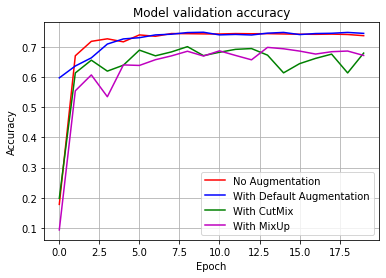

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'm')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Default Augmentation', 'With CutMix', 'With MixUp'], loc='lower right')
plt.grid(True)
plt.show()

## 5. Augmentation에 의한 모델 성능 비교

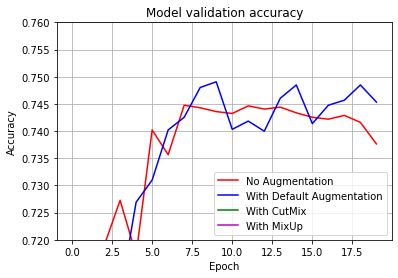

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'm')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Default Augmentation', 'With CutMix', 'With MixUp'], loc='lower right')
plt.grid(True)
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

- 기본 Augmentation을 적용하였을 경우 validation accuracy가 가장 높습니다.
- Augmentation 적용을 통해 Augmentaion 미적용시 대비 0.5% 이상의 성능향상을 확인할 수 있습니다.
- Cutmix와 Mixup을 적용한 데이터셋으로 학습시킨 경우 생각보다 성능이 저조합니다.
  <br>=> Cutmix의 경우 랜덤영역를 잘라 붙이므로 상관없는 영역이 크롭된 경우가 생깁니다.
  <br>=> Mixup의 경우 이미지 내 강아지의 크기가 제각각 다르고 사람이 있는 데이터셋이 많습니다.

<br>

___
## 회고
간단한 augmentation부터 cutmix, mixup과 같은 여러 가지 변형된 augmentation 기법들을 직접 실습해볼 수 있어서 좋았습니다. augmentation을 한 경우의 성능 향상이 epoch 수가 일정 수준 이상이 되어야 나타난다는 점을 알게 되어 추후 augmentation기법을 사용한다면 epoch 수를 고려해야 될 것 같습니다.